In [ ]:
!pip install torch-scatter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=3566953 sha256=29e6fc3be3490d4404f02762ad8c6218ad65c8878bab379e299b2c1851fccb65
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter


In [ ]:
!pip install torch-sparse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 9.0 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.15-cp37-cp37m-linux_x86_64.whl size=1742304 sha256=e94e494407f1f0967fd7730ef6fc5cad6c7c9ce0f0e59bcb7492c25a88e81b5e
  Stored in directory: /root/.cache/pip/wheels/15/68/4d/1414be5c2c622bad35364e13213180797717b6d4b8923936dc
Successfully built torch-sparse


In [ ]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 7.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=a00197b5e46eb98ef2d5c59fd15bd71849c215907f6bd85e50b5a6f7ff5ae29e
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [ ]:
import torch
from torch_geometric.datasets import QM9
from  torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv,global_add_pool
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [ ]:
dset=QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [ ]:
data=dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [ ]:
data.z

tensor([6, 1, 1, 1, 1])

In [ ]:
data.new_attribute=torch.tensor([1,2,3])

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [ ]:
data.to(device)

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [ ]:
from torch.utils.data import random_split
train_set,valid_set,test_set=random_split(dset,[110000,10831,10000])

In [ ]:
trainloader=DataLoader(train_set,batch_size=32,shuffle=True)
validloader=DataLoader(valid_set,batch_size=32,shuffle=True)
testloader=DataLoader(test_set,batch_size=32,shuffle=True)

In [ ]:
class ExampleNet(torch.nn.Module):
  def __init__(self,num_node_features,num_edge_features):
    super().__init__()
    conv1_net=nn.Sequential(nn.Linear(num_edge_features,32),nn.ReLU(),nn.Linear(32,num_node_features*32))
    conv2_net=nn.Sequential(nn.Linear(num_edge_features,32),nn.ReLU(),nn.Linear(32,16*32))
    self.conv1=NNConv(num_node_features,32,conv1_net)
    self.conv2=NNConv(32,16,conv2_net)
    self.fc_1=nn.Linear(16,32)
    self.out=nn.Linear(32,1)

  def forward(self,data):
    batch,x,edge_index,edge_attr=(data.batch,data.x,data.edge_index,data.edge_attr)
    #first graph conv layer
    x=F.relu(self.conv1(x,edge_index,edge_attr))
    x=F.relu(self.conv2(x,edge_index,edge_attr))
    x=global_add_pool(x,batch)
    x=F.relu(self.fc_1(x))
    output=self.out(x)
    return output  


In [ ]:
#initialize the model
num_nodes,num_edges=11,4
net=ExampleNet(num_nodes,num_edges)
optimizer=torch.optim.Adam(net.parameters(),lr=0.01)
epochs=15
target_idx=1
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
for total_epochs in range(epochs):
  epoch_loss=0
  total_graphs=0
  net.train()
  for batch in trainloader:
    batch.to(device)
    optimizer.zero_grad()
    output=net(batch)
    loss=F.mse_loss(output,torch.unsqueeze(batch.y[:,target_idx],1))
    loss.backward()
    epoch_loss+=loss.item()
    total_graphs+=batch.num_graphs
    optimizer.step()
  train_avg_loss=epoch_loss/total_graphs  
  val_loss=0
  total_graphs=0
  net.eval()
  for batch in validloader:
    batch.to(device)
    output=net(batch)
    loss=F.mse_loss(output,torch.unsqueeze(batch.y[:,target_idx],1))
    val_loss+=loss.item()
    total_graphs+=batch.num_graphs
  val_avg_loss=val_loss/total_graphs
  print(f"Epochs:{total_epochs} |"
        f"epoch avg.loss:{train_avg_loss:.2f} |"
        f"validation avg.loss:{val_avg_loss:.2f}")    



Epochs:0 |epoch avg.loss:0.52 |validation avg.loss:0.11
Epochs:1 |epoch avg.loss:0.13 |validation avg.loss:0.08
Epochs:2 |epoch avg.loss:0.10 |validation avg.loss:0.10
Epochs:3 |epoch avg.loss:0.09 |validation avg.loss:0.05
Epochs:4 |epoch avg.loss:0.08 |validation avg.loss:0.07
Epochs:5 |epoch avg.loss:0.08 |validation avg.loss:0.08
Epochs:6 |epoch avg.loss:0.08 |validation avg.loss:0.05
Epochs:7 |epoch avg.loss:0.07 |validation avg.loss:0.05
Epochs:8 |epoch avg.loss:0.07 |validation avg.loss:0.06
Epochs:9 |epoch avg.loss:0.07 |validation avg.loss:0.06
Epochs:10 |epoch avg.loss:0.07 |validation avg.loss:0.05
Epochs:11 |epoch avg.loss:0.07 |validation avg.loss:0.07
Epochs:12 |epoch avg.loss:0.07 |validation avg.loss:0.05
Epochs:13 |epoch avg.loss:0.06 |validation avg.loss:0.17
Epochs:14 |epoch avg.loss:0.06 |validation avg.loss:0.07


In [ ]:
net.eval()
predictions=[]
real=[]
for batch in testloader:
  output=net(batch.to(device))
  predictions.append(output.detach().cpu().numpy())
  real.append(batch.y[:,target_idx].detach().cpu().numpy())
real=np.concatenate(real)
predictions=np.concatenate(predictions)  

Text(0, 0.5, 'Predicted Isotrophic Polarizability')

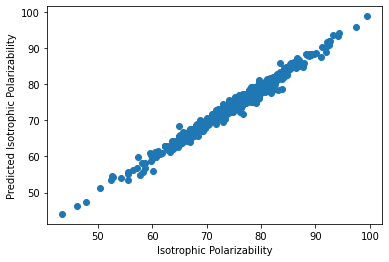

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(real[:500],predictions[:500])
plt.xlabel('Isotrophic Polarizability')
plt.ylabel('Predicted Isotrophic Polarizability')

In [ ]:
real

array([82.52, 76.4 , 77.71, ..., 76.99, 77.45, 54.71], dtype=float32)